# 1 - Multi-armed bandits (3 pts.)
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.

Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.  
You will compare the average reward received by:  
>• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;  
    • An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • The UCB policy. 

To do this

1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0 and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

**Question 1. Using the results from the procedure outlined above, plot the average reward obtained with each policy during the 1, 000 steps in a single plot. Comment the differences observed.**

### Notes

A greedy policy is an ε-greedy policy with ε = 0;  
NumPy provides a normal distribution: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html;

Logic is given by:


![image.info](./pictures/bandit.png)


Previous image is from the *Reinforcement Learning: An Introduction* book, by Sutton and Barto, found in:  
http://incompleteideas.net/sutton/book/the-book-2nd.html

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Generic Bandit class

In [237]:
# Attempt a simple bandit

class Bandit(object):
    
    # Variable initialization
    def __init__(self, n_actions=10, iterations=1000, use_ucb=True, initial_qa=0.0, update_qa=True, epsilon=0.0, c=0.0):
        # Set the size of action space
        self.n_actions = n_actions
        
        # Initial Q(a) values
        self.q_actions = np.array([initial_qa for i in np.arange(self.n_actions)])
        
        # Value of picking an action
        self.rewards = self.__generate_normal__()
        
        # Times chosen each action
        self.times_chosen = np.zeros(self.n_actions)
        
        # Number of iteration
        self.max_iterations = iterations
        
        # Number of timesteps
        self.timestep = 0
        
        # Whether we used or not the UCB
        self.is_UCB = use_ucb
        
        # Epsilon for greedy - greedy is 1-
        self.epsilon = epsilon
        
        # Constant C value for UCB
        self.c_value = c
        
        # Do we update the action-values
        self.update_qa = update_qa
        
        # Total reward
        self.total_reward = 0.0
        
        # Records
        self.records = None
        
    # Return an array of 10 values sampled from a normal distribution
    def __generate_normal__(self, mean=0.0, variance=1.0):
        return np.random.normal(mean, variance, self.n_actions)
    
    # Get Q(a) at timestep n+1
    def __update_action_value__(self, current_q, current_r, times_chosen):
        next_qa = current_q + (current_r - current_q) * (times_chosen ** -1)
        return next_qa
        
    # Pick action A at t+1
    def __select_action_ucb__(self):
        next_action = np.argmax([self.q_actions[i] + 
                                 self.c_value * np.sqrt(np.log(self.timestep) / 
                                                        (self.times_chosen[i] + 10e-7)) 
                                 for i in np.arange(self.n_actions)])
        return next_action
    
    
    def __select_action_epsilon__(self):
        if np.random.random() <= self.epsilon:
            known_action = np.argmax(self.q_actions)
            
            # Generate probs for each action
            prob_actions = self.__generate_normal__()
            prob_actions[known_action] = -999
            return np.argmax(prob_actions)
        else:
            return np.argmax(self.q_actions)
        
        
    def __complete_records__(self, total_reward, action_picked, reward_received):
        new_df = pd.DataFrame({'Cumulative Reward': total_reward,
                               'Picked Action': action_picked,
                               'Reward Received': reward_received}, 
                              index=np.arange(1, len(total_reward)+1))
        new_df['Average Reward'] = new_df['Cumulative Reward'].values / np.arange(1, len(total_reward)+1)
        
        return new_df
            
            
    def iterate(self):
        # 1 - Initialize Q(a) -> done on class initialization
        # 2 - Initialize rewards from normal distribution
        # 3 - If is UBC, pick each action exactly once first
        # 4 - Pick action based on the UCB or greedy
        # 5 - Get reward for action selected
        # 6 - Update counter of selection for action selected
        # 7 - Get new Q(a) for the selected action
        
        #df = pd.DataFrame({})
        
        records_total_reward = np.array([])
        records_action_picked = np.array([])
        records_reward_received = np.array([])
        
        if self.is_UCB:
            # Pick each action once
            for action in np.arange(self.n_actions):
                self.times_chosen[action] += 1
                self.timestep += 1
                if self.update_qa:
                    updated_qa = self.__update_action_value__(current_q=self.q_actions[action],
                                                              current_r=self.rewards[action],
                                                              times_chosen=self.times_chosen[action])
                    self.q_actions[action] = updated_qa
                self.total_reward += self.rewards[action]

                records_total_reward = np.append(records_total_reward, self.total_reward)
                records_action_picked = np.append(records_action_picked, action)
                records_reward_received = np.append(records_reward_received, self.rewards[action])
        
        for iteration in np.arange(self.max_iterations):
            # Pick action
            picked_action = 0
            if self.is_UCB:
                picked_action = self.__select_action_ucb__()
            else:
                picked_action = self.__select_action_epsilon__()


            # Update timestep and action counter
            self.times_chosen[picked_action] += 1
            self.timestep += 1

            # Update Q(a)
            if self.update_qa:
                updated_qa = self.__update_action_value__(current_q=self.q_actions[picked_action], 
                                                          current_r=self.rewards[picked_action],
                                                          times_chosen=self.times_chosen[picked_action])
                self.q_actions[picked_action] = updated_qa
            
            self.total_reward += self.rewards[picked_action]
            
            records_total_reward = np.append(records_total_reward, self.total_reward)
            records_action_picked = np.append(records_action_picked, picked_action)
            records_reward_received = np.append(records_reward_received, self.rewards[picked_action])
        
        self.records = self.__complete_records__(records_total_reward, records_action_picked,
                                                 records_reward_received)
        
        return self.records
    
    
    def plot_rewards(self, title=None):
        if self.records is not None:
            
            fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

            axs[0].plot(self.records['Cumulative Reward'])
            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Cumulative Reward')
            axs[0].set_title('Cumulative Reward over Iterations')

            axs[1].plot(self.records['Average Reward'])
            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Average Reward')
            axs[1].set_title('Average Reward over Iterations')
            
            axs[2].plot(self.records['Reward Received'])
            axs[2].set_xlabel('Iterations')
            axs[2].set_ylabel('Reward Received')
            axs[2].set_title('Reward Received over Iterations')
            
            fig.suptitle(title, fontsize=14)

            plt.show()

## Test example

In [238]:
# Instantiate the Bandit class for UCB with C=0.2 (for test)

bandit = Bandit(iterations=2000, use_ucb=True, epsilon=0.0, c=0.2, update_qa=True)
bandit.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward
1,-0.628135,0.0,-0.628135,-0.628135
2,-1.334815,1.0,-0.706680,-0.667407
3,-0.653600,2.0,0.681215,-0.217867
4,-1.425169,3.0,-0.771569,-0.356292
5,-1.700190,4.0,-0.275022,-0.340038
...,...,...,...,...
2006,3635.487376,5.0,1.822681,1.812307
2007,3637.310058,5.0,1.822681,1.812312
2008,3639.132739,5.0,1.822681,1.812317
2009,3640.955420,5.0,1.822681,1.812322


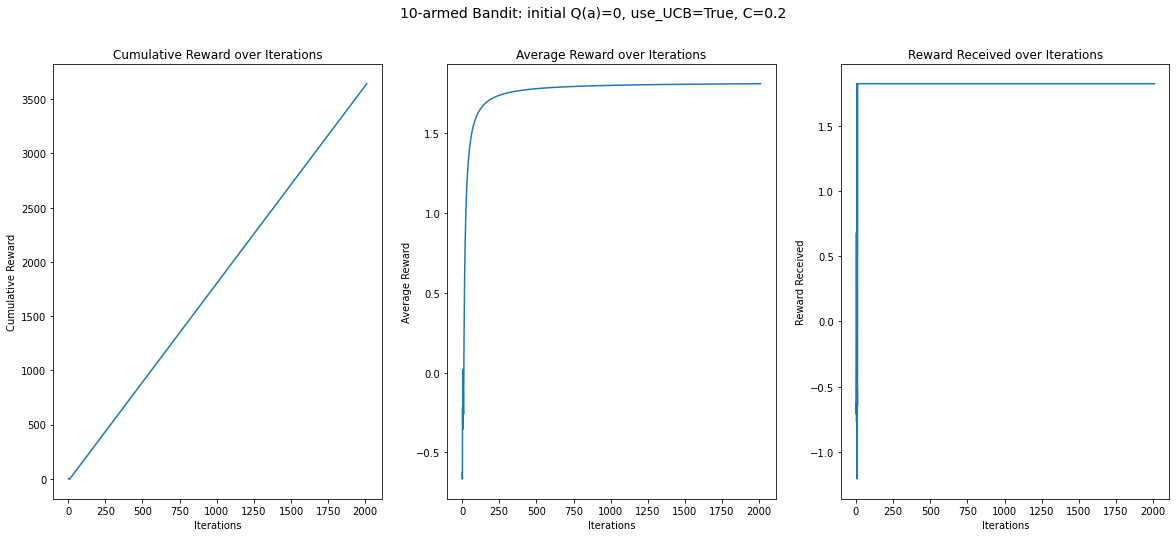

In [240]:
# Plot the Cumulative Reward and Average Reward (for test)

bandit.plot_rewards('10-armed Bandit: initial Q(a)=0, use_UCB=True, C=0.2')

## MultiBandit class

In [276]:
# Define a class for running multiple instances of a 10-armed bandit problem

class MultiBandit(object):
    
    def __init__(self, experiment_iter=2000, bandit_iter=1000, number_actions=10,
                 use_UCB=False, c=0, epsilon=0, initial_qa=0, update_qa=True, column=None):
        
        # Number of bandits to run
        self.experiment_iter = experiment_iter
        
        # Iterations of each bandit
        self.bandit_iter = bandit_iter
        
        # Action space size for each bandit
        self.number_actions = number_actions
        
        # If use UCB
        self.use_UCB = use_UCB
        
        # C value for the UCB
        self.c = c
        
        # Epsilon for epsilon-greedy
        self.epsilon = epsilon
        
        # Initial Q(a) values
        self.initial_qa = initial_qa
        
        # Do we update the Q(a)?
        self.update_qa = update_qa
        
        # Bandit dictionary collection
        self.bandit_records = {}
        
        # Column to analyze
        self.column = column
        
        # Averaged results
        self.results = None

    def __multi_bandit__(self, experiment_iter, bandit_iter, number_actions=10, use_UCB=False, 
                         c=0, epsilon=0, initial_qa=0, update_qa=True):

        for i in tqdm.notebook.trange(self.experiment_iter):
            temp_bandit = Bandit(n_actions=self.number_actions, iterations=self.bandit_iter, 
                                 use_ucb=self.use_UCB, c=self.c, initial_qa=self.initial_qa, update_qa=self.update_qa)
            temp_bandit.iterate()

            self.bandit_records['Run {:0004d}'.format(i+1)] = temp_bandit

        return


    # Get the averaged results for a column
    def __average_results__(self, dictionary, column):
        if self.column is not None:
            current_results = {}
            for run in tqdm.notebook.trange(len(dictionary)):
                current_results[list(dictionary.keys())[run]] = dictionary[list(dictionary.keys())[run]].records[column]

            return pd.DataFrame(current_results)
        else:
            return
        
        
    def iterate(self):
        self.__multi_bandit__(experiment_iter=self.experiment_iter, bandit_iter=self.bandit_iter, 
                              number_actions=self.number_actions, use_UCB=self.use_UCB, epsilon=self.epsilon, 
                              initial_qa=self.initial_qa, update_qa=self.update_qa)
        self.results = self.__average_results__(self.bandit_records, self.column)
        
        return self.results
        

In [277]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;

greedy_bandit_q0 = MultiBandit(use_UCB=False, epsilon=0, initial_qa=0, column='Average Reward')
greedy_bandit_q0.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-0.516557,-2.240672,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-1.707267,1.111025,...,0.492283,-1.742795,-0.50431,-0.663523,0.759511,0.568184,-1.071230,-1.434055,-2.373735,-0.515341
2,-0.516557,-0.929246,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-1.564760,1.111025,...,0.492283,-0.981482,-0.50431,-0.663523,0.759511,0.568184,-0.849524,-0.833298,-1.880514,-0.515341
3,-0.516557,-0.492104,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-1.346166,1.111025,...,0.492283,-0.727712,-0.50431,-0.663523,0.759511,0.568184,-0.775622,-0.633046,-1.564326,-0.515341
4,-0.516557,-0.273533,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-1.236869,1.111025,...,0.492283,-0.600826,-0.50431,-0.663523,0.759511,0.568184,-0.738672,-0.532920,-1.406233,-0.515341
5,-0.516557,-0.142391,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-1.171291,1.111025,...,0.492283,-0.524695,-0.50431,-0.663523,0.759511,0.568184,-0.716501,-0.472844,-1.311376,-0.515341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-0.516557,0.379546,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-0.910295,1.111025,...,0.492283,-0.221699,-0.50431,-0.663523,0.759511,0.568184,-0.628264,-0.233748,-0.933856,-0.515341
997,-0.516557,0.379549,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-0.910293,1.111025,...,0.492283,-0.221697,-0.50431,-0.663523,0.759511,0.568184,-0.628264,-0.233747,-0.933854,-0.515341
998,-0.516557,0.379551,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-0.910292,1.111025,...,0.492283,-0.221696,-0.50431,-0.663523,0.759511,0.568184,-0.628263,-0.233745,-0.933852,-0.515341
999,-0.516557,0.379554,-0.396401,1.377251,0.568117,0.776196,1.522462,1.221721,-0.910291,1.111025,...,0.492283,-0.221694,-0.50431,-0.663523,0.759511,0.568184,-0.628263,-0.233744,-0.933851,-0.515341


In [278]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;

greedy_bandit_q5 = MultiBandit(use_UCB=False, epsilon=0, initial_qa=5, column='Average Reward')
greedy_bandit_q5.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-1.106214,0.200820,1.370300,-0.979372,-0.301394,-0.136923,0.754316,0.951689,0.328199,0.760542,...,-1.663413,0.263023,-0.124925,-0.230462,-0.474093,-1.299113,-0.599179,-1.985616,0.188371,-0.094622
2,-0.523663,0.735020,0.669659,-0.209028,-0.583840,-0.232648,0.080992,0.445519,-1.250661,0.136231,...,-1.824517,0.761162,0.343882,-0.154637,-0.361419,-0.367615,0.469030,-1.368938,0.622969,-0.686307
3,-0.511305,0.737896,0.606061,-0.029142,-0.666270,-0.542891,-0.569558,0.117993,-0.653276,-0.240828,...,-0.726258,0.412140,0.753351,0.303204,-0.633544,-0.218621,0.456012,-0.963075,-0.135692,-0.695443
4,-0.635657,0.204874,-0.079018,0.018782,-0.448974,-0.822191,-0.434574,0.021434,-0.127320,-0.144549,...,-0.860099,0.191935,0.909747,0.305032,-0.389223,-0.307299,0.321529,-1.079367,-0.199813,-0.620972
5,-0.411425,0.216165,-0.201118,0.044762,-0.152571,-0.604714,-0.563158,0.086913,-0.267724,-0.270071,...,-0.992027,0.502446,0.403240,-0.138862,-0.160322,-0.670313,0.374983,-0.743630,0.113059,-0.515847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.054211,1.257302,2.417352,2.035134,1.023699,2.114275,1.861751,0.940171,1.434309,2.468571,...,1.452672,2.447026,1.557302,1.204442,1.839108,1.578145,1.520160,1.437153,1.048305,-0.096559
997,0.054216,1.257314,2.417373,2.035156,1.023709,2.114296,1.861773,0.940183,1.434326,2.468597,...,1.452690,2.447046,1.557317,1.204456,1.839130,1.578165,1.520177,1.437170,1.048315,-0.096557
998,0.054220,1.257326,2.417395,2.035177,1.023718,2.114318,1.861795,0.940195,1.434342,2.468622,...,1.452707,2.447066,1.557332,1.204471,1.839153,1.578185,1.520194,1.437186,1.048324,-0.096555
999,0.054225,1.257338,2.417416,2.035199,1.023727,2.114339,1.861817,0.940206,1.434358,2.468648,...,1.452725,2.447086,1.557347,1.204485,1.839175,1.578205,1.520211,1.437202,1.048333,-0.096553


In [279]:
# An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  

egreedy_bandit_e01 = MultiBandit(use_UCB=False, epsilon=0.1, initial_qa=0, column='Average Reward')
egreedy_bandit_e01.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-1.006626,-0.563357,-1.183449,-0.061993,1.066891,...,-1.025777,-0.190968,-1.007179,-1.064113,0.832275,0.659603,-1.616336,1.954157,0.847839,-0.627942
2,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.716356,-0.563357,-2.081059,-0.061993,1.066891,...,0.017157,-0.190968,-0.158880,-0.266448,0.832275,0.659603,-0.464447,1.954157,0.847839,-0.627942
3,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.619599,-0.563357,-1.156514,-0.061993,1.066891,...,0.364801,-0.190968,0.123886,-0.000559,0.832275,0.659603,-0.080484,1.954157,0.847839,-0.627942
4,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.571220,-0.563357,-0.694241,-0.061993,1.066891,...,0.538623,-0.190968,0.265269,0.132385,0.832275,0.659603,0.111497,1.954157,0.847839,-0.627942
5,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.542193,-0.563357,-0.416877,-0.061993,1.066891,...,0.642917,-0.190968,0.350099,0.212152,0.832275,0.659603,0.226686,1.954157,0.847839,-0.627942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.426668,-0.563357,0.687007,-0.061993,1.066891,...,1.057996,-0.190968,0.687715,0.529616,0.832275,0.659603,0.685129,1.954157,0.847839,-0.627942
997,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.426667,-0.563357,0.687013,-0.061993,1.066891,...,1.057998,-0.190968,0.687716,0.529618,0.832275,0.659603,0.685131,1.954157,0.847839,-0.627942
998,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.426667,-0.563357,0.687018,-0.061993,1.066891,...,1.058000,-0.190968,0.687718,0.529619,0.832275,0.659603,0.685133,1.954157,0.847839,-0.627942
999,-0.366781,-0.778162,-0.306702,-0.028904,0.606486,-0.426666,-0.563357,0.687024,-0.061993,1.066891,...,1.058002,-0.190968,0.687720,0.529621,0.832275,0.659603,0.685136,1.954157,0.847839,-0.627942


In [280]:
# An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  

egreedy_bandit_e001 = MultiBandit(use_UCB=False, epsilon=0.001, initial_qa=0, column='Average Reward')
egreedy_bandit_e001.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-0.489633,-1.472835,-1.408709,-1.452959,-0.328238,1.411925,-0.979688,0.713281,-1.658776,-0.06682,...,-1.486904,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,-1.968445,0.318087,0.68889
2,-0.489633,-0.637235,-0.239706,-0.271792,-0.328238,1.411925,-0.979688,0.713281,-0.660448,-0.06682,...,-1.016015,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,-0.374350,0.318087,0.68889
3,-0.489633,-0.358702,0.149962,0.121930,-0.328238,1.411925,-0.979688,0.713281,-0.327672,-0.06682,...,-0.859053,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,0.157014,0.318087,0.68889
4,-0.489633,-0.219435,0.344796,0.318791,-0.328238,1.411925,-0.979688,0.713281,-0.161284,-0.06682,...,-0.780571,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,0.422697,0.318087,0.68889
5,-0.489633,-0.135875,0.461696,0.436908,-0.328238,1.411925,-0.979688,0.713281,-0.061451,-0.06682,...,-0.733482,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,0.582106,0.318087,0.68889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-0.489633,0.196687,0.926950,0.907003,-0.328238,1.411925,-0.979688,0.713281,0.335875,-0.06682,...,-0.546072,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,1.216543,0.318087,0.68889
997,-0.489633,0.196688,0.926952,0.907005,-0.328238,1.411925,-0.979688,0.713281,0.335877,-0.06682,...,-0.546071,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,1.216546,0.318087,0.68889
998,-0.489633,0.196690,0.926954,0.907007,-0.328238,1.411925,-0.979688,0.713281,0.335880,-0.06682,...,-0.546070,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,1.216550,0.318087,0.68889
999,-0.489633,0.196692,0.926957,0.907010,-0.328238,1.411925,-0.979688,0.713281,0.335882,-0.06682,...,-0.546069,-0.905703,-0.488072,1.327377,0.329718,-0.314962,-0.018433,1.216553,0.318087,0.68889


In [281]:
# The UCB policy. Arbitrarily chose 0.5 for C

ucb_bandit_05 = MultiBandit(use_UCB=True, c=0.5, initial_qa=0, column='Average Reward')
ucb_bandit_05.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,1.069941,0.870466,-0.584445,0.769026,0.714384,-1.618871,0.487603,1.227258,-0.424594,0.271821,...,-0.141752,0.945424,0.627324,-0.642167,0.636121,-1.463741,-0.390819,-0.426569,-0.960464,-0.628347
2,0.241762,0.704590,-0.211484,0.762924,1.311771,-1.323570,0.593868,1.919808,-0.010110,0.671643,...,-0.021143,1.446247,0.099477,-0.127964,1.176007,0.047265,0.017090,-0.810469,-1.126696,-0.834203
3,-0.065340,-0.481850,0.353051,0.258956,0.604133,-0.714141,0.184720,0.950019,0.055262,0.351849,...,0.369541,1.003674,-0.135167,-0.154214,0.350018,0.225677,-0.248972,-0.896617,-1.288012,-0.662010
4,0.033636,-0.908383,-0.023738,0.198156,0.763633,-0.418856,-0.270568,0.845927,-0.061646,0.681773,...,0.456570,0.894775,-0.099861,-0.371309,0.737465,0.220730,-0.268461,-1.139135,-0.949858,-0.570709
5,0.187778,-1.040396,-0.203509,0.832984,0.323492,-0.464868,0.069278,0.523954,-0.003225,0.562282,...,-0.015680,0.626785,0.035938,-0.543188,0.814749,0.263448,0.133807,-0.951706,-0.739012,-0.605981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,1.050973,1.964051,1.699035,3.345171,2.160224,1.230092,1.375129,2.588169,2.031544,1.299498,...,1.172112,1.516196,1.446314,-0.098230,1.555229,1.341185,1.488550,-0.255592,0.258493,-0.249931
1007,1.050992,1.964082,1.698820,3.345198,2.160243,1.230116,1.375182,2.588193,2.031567,1.299867,...,1.172174,1.516319,1.446343,-0.098338,1.555220,1.341401,1.488803,-0.256004,0.258674,-0.249978
1008,1.051011,1.964113,1.699093,3.345225,2.160263,1.230141,1.375097,2.588217,2.031590,1.300147,...,1.172153,1.516746,1.446372,-0.098656,1.555379,1.341289,1.488600,-0.256123,0.257465,-0.250471
1009,1.051029,1.964143,1.698878,3.345252,2.160282,1.230165,1.375185,2.588241,2.031613,1.299950,...,1.172214,1.516259,1.446401,-0.098949,1.555721,1.341230,1.488852,-0.255804,0.257273,-0.250414


## Plot the results

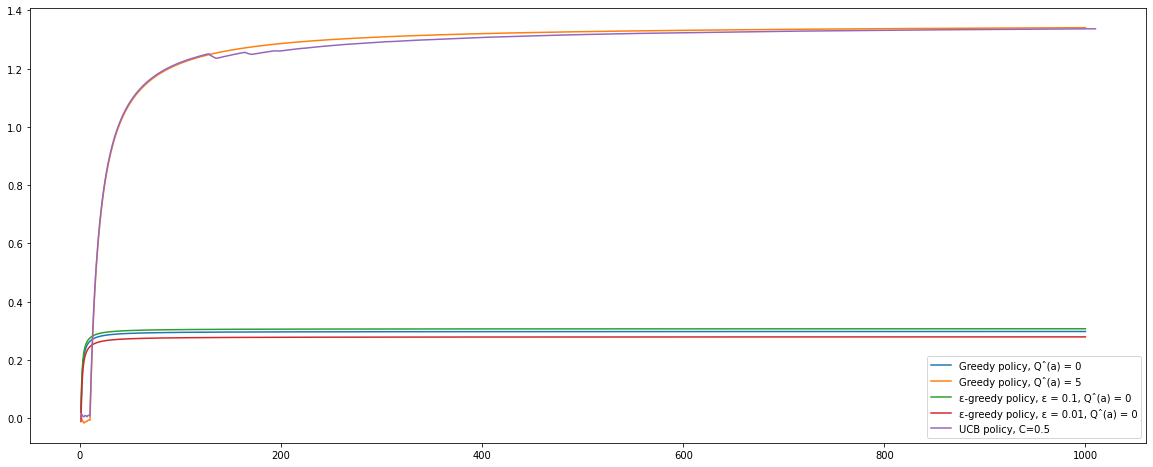

In [291]:
# 1 - Get the means of steps across the runs of a policy
# 2 - Plot each timestep across the policies

fig = plt.figure(figsize=(20, 8))

# Greedy with Q(a) = 0
plt.plot(greedy_bandit_q0.results.index.values, greedy_bandit_q0.results.mean(axis=1))

# Greedy with Q(a) = 5
plt.plot(greedy_bandit_q5.results.index.values, greedy_bandit_q5.results.mean(axis=1))

# Epsilon at 0.1
plt.plot(egreedy_bandit_e01.results.index.values, egreedy_bandit_e01.results.mean(axis=1))

# Epsilon at 0.01
plt.plot(egreedy_bandit_e001.results.index.values, egreedy_bandit_e001.results.mean(axis=1))

# UCB at C=0.5
plt.plot(ucb_bandit_05.results.index.values, ucb_bandit_05.results.mean(axis=1))

plt.legend(['Greedy policy, Qˆ(a) = 0', 
            'Greedy policy, Qˆ(a) = 5',
            'ε-greedy policy, ε = 0.1, Qˆ(a) = 0',
            'ε-greedy policy, ε = 0.01, Qˆ(a) = 0',
            'UCB policy, C=0.5'
            ])

plt.show()